# Détection de menaces radar

## Mission

Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    - train
    - test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

    - Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
    - Sélection d'un algorithme naïf de référence: vous définissez un premier algorithme ad hoc et à la main et caractérisez ses performances 
    - Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
    - Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"
    
Vous pouvez ouvrir un fichier de la façon suivante:
    

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Lecture des données

#### Lecture des labels

In [ ]:
with open('./train_labels.json') as f: 
    dict_labels = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


In [ ]:
with open('./test_labels.json') as f: 
    dict_labels_test = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels_test[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: menace
Le signal pdw-1.npz est de type: menace
Le signal pdw-2.npz est de type: nonmenace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: nonmenace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: menace


#### Lecture des features

In [ ]:
import os
import pandas as pd

def read_data(directory, type = "train"):
  """
  Une fonction qui lit les fichiers de signal (.npz) et retourne un data frame des données avec leurs labels
  directory : Le path vers le dossier qui contient les données
  type : Le type des données (train ou test)
  return : un data frame contenant les données et leurs labels
  """
  directory = directory
  df = pd.DataFrame()
  df_labels = pd.DataFrame()
  for file in tqdm(os.listdir(directory)):
      # Check si les fichiers sont bien dans le format .npz
      if file.endswith(".npz"):
          # extraire le numero du fichier pdw-xyz.npz ==> num = xyz pour pouvoir l'utiliser à identifier le label
          num = ''.join(filter(lambda i: i.isdigit(), file))
          # load les données du fichier 
          pdws = np.load(directory + file)
          # Ajouter les données de ce signal dans la dataframe
          data = [df, pd.DataFrame.from_dict({item: [pdws[item]] for item in pdws.files}, orient='index').T]
          df = pd.concat(data)
          #mettre label 1 si menace 0 sinon
          if type == "train":
            label = 1 if dict_labels[f'pdw-{num}'] == "menace" else 0
          elif type == "test":
            label = 1 if dict_labels_test[f'pdw-{num}'] == "menace" else 0
          else:
            raise Exception("Type est égale soit à train ou test.")
          # Ajouter le label de ce signal dans la dataframe des labels
          labels = [df_labels, pd.DataFrame([label])]
          df_labels = pd.concat(labels)
  # Mettrle les données du signal et leurs labels dans la même dataframe
  df['label'] = df_labels[0]
  return df

In [ ]:
DIRECTORY_TRAIN = './train/train/'
DIRECTORY_TEST = './test/test/'

In [ ]:
df_train = read_data(DIRECTORY_TRAIN)
df_test = read_data(DIRECTORY_TEST, type = "test")

100%|██████████| 800/800 [00:07<00:00, 105.29it/s]


In [ ]:
#Stocker une copie originale des dataframes qu'on peut utiliser après sans devoir relire tous les fichiers .npz
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

In [ ]:
#Afficher les 5 premiers signaux de notre dataframe du training
df_train.head()

,date,largeur,frequence,puissance,theta,phi,label
0,"[2.3850000000000002, 10.295, 13.892, 15.33, 26...","[0.089, 0.09, 0.09, 0.09, 0.09, 0.091, 0.089, ...","[4.650505099052205, 4.666309635660842, 4.64756...","[-106.40904461472772, -106.88363724102098, -10...","[0.0037470154538509493, -0.0425199376557501, 0...","[1.4637946571474683, 1.7376194911378546, 1.597...",0
0,"[5.322, 7.026, 8.727, 8.97, 9.944, 10.429, 13....","[0.029, 0.027, 0.029, 0.029, 0.027, 0.027, 0.0...","[1.9213489264158359, 1.9124647925757723, 1.925...","[-127.94454697066773, -127.01740840617288, -12...","[-0.8608606907920762, -1.1109595030657935, -1....","[1.5708103500706487, 1.3960805606605136, 1.688...",1
0,"[3.119, 5.812, 7.495, 13.893, 17.262, 18.945, ...","[0.03, 0.031, 0.031, 0.03, 0.031, 0.031, 0.03,...","[2.3958530384436334, 2.3780176267052817, 2.400...","[-146.35500943579984, -147.00761637160338, -14...","[-2.229007468043361, -2.0897812144657935, -2.0...","[1.4079337515226875, 1.6210076484678198, 1.776...",0
0,"[26.751, 32.692, 56.465, 68.353, 75.287, 82.21...","[0.209, 0.209, 0.209, 0.20700000000000002, 0.2...","[2.3925424793977546, 2.389100929097443, 2.3860...","[-127.8055353501821, -127.96575253604672, -137...","[0.9886985354315367, 0.7389723008706994, 0.828...","[1.7668140337753788, 1.3253246619892987, 1.601...",1
0,"[15.696, 17.657, 64.688, 82.32600000000001, 94...","[0.089, 0.089, 0.089, 0.089, 0.089, 0.091, 0.0...","[1.3743776212342522, 1.368049445365479, 1.3657...","[-148.7012634828696, -147.97189957344415, -141...","[-2.292942265650137, -2.050376162167706, -1.97...","[1.5270867498322644, 1.8227204355635058, 1.498...",0


In [ ]:
#Afficher les 5 premiers signaux de notre dataframe du test
df_test.head()

,date,largeur,frequence,puissance,theta,phi,label
0,"[11.63, 17.506, 29.263, 32.202, 46.898, 57.183...","[0.275, 0.275, 0.273, 0.273, 0.273, 0.275, 0.2...","[0.8906051506956049, 0.9939573749362038, 1.020...","[-97.2832478198323, -98.1766145572355, -98.814...","[-3.0382231134710316, -2.8494861423263496, -2....","[1.7378443194687776, 1.805356286967098, 1.7977...",1
0,"[7.237, 8.715, 13.144, 22.001, 26.432000000000...","[0.279, 0.28, 0.278, 0.278, 0.279, 0.278, 0.28...","[1.3325405245589292, 1.3371907160884844, 1.332...","[-141.53452000954488, -140.9613354254435, -141...","[-1.6591222701912707, -1.9225926149330628, -2....","[1.5317826808273285, 1.671787908362508, 1.6743...",0
0,"[8.356, 8.875, 12.515, 52.02, 55.138, 61.375, ...","[0.07200000000000001, 0.07200000000000001, 0.0...","[3.3394624458271362, 3.3563332322300083, 3.327...","[-119.63678933700994, -118.99653225298873, -11...","[2.9610415351467294, 2.9204828088386625, 2.788...","[1.8061905221658041, 1.8137590373907984, 1.682...",0
0,"[17.385, 46.437, 59.512, 68.227, 78.398, 90.01...","[0.13, 0.129, 0.128, 0.129, 0.13, 0.128, 0.129...","[1.540237617346451, 1.5367485886875472, 1.5323...","[-117.97490135699024, -114.80852092087243, -11...","[1.4836218235176166, 1.5684588356902338, 1.331...","[1.394730294037142, 1.6879153556753024, 1.6241...",0
0,"[23.78, 28.952, 35.162, 40.333, 62.063, 70.34,...","[0.249, 0.25, 0.249, 0.248, 0.249, 0.25, 0.249...","[1.257851290900774, 1.2610093911363802, 1.2622...","[-138.2164398933527, -127.01533236379927, -123...","[0.025498416430459248, -0.1715227848245161, 0....","[1.5842478052457605, 1.6725163692805622, 1.444...",1


In [ ]:
print(f"Le premier signal dans la dataframe du training contient {df_train.iat[0, 0].shape[0]} impulsions.")
print(f"Le deuxième signal dans la dataframe du training contient {df_train.iat[1, 0].shape[0]} impulsions.")

Le premier signal dans la dataframe du training contient 1365 impulsions.
Le deuxième signal dans la dataframe du training contient 4065 impulsions.


On constate que nos jeux de données se diffèrent d'un signal à un autre. D'abord, chaque signal contient plusieurs impulsions ce qui veut dire plusieurs valeurs pour chaque feature. En plus, chaque signal a un nombre différent d'impulsions. Ainsi, la première étape est d'analyser les données afin d'extraire les informations les plus pertinentes pour pouvoir entrainer des modèles Machine Learning.

### Analyse des données:

In [ ]:
print(f"La data frame du trainig contient {df_train.shape[0]} signaux avec {df_train.shape[1]} features en comptant le label.")
print(f"La data frame du test contient {df_test.shape[0]} signaux avec {df_test.shape[1]} features en comptant le label.")

La data frame du trainig contient 2000 signaux avec 7 features en comptant le label.
La data frame du test contient 800 signaux avec 7 features en comptant le label.


Tant que chaque signal contient une liste des données temporelles (date, puissance, fréquence ...) et pour chaque signal on a un nombre différent des points, donc on ne peut pas voir la distribution des features sur tous les signaux en général. Ainsi, on va essayer d'afficher deux signaux différents; un signal sans menace et l'autre avec menace afin de pouvoir en extraire les différentes dissimilaritées.

In [ ]:
#Extraire les descripteurs d'un signal sans menace
dates = df_train.iat[0, 0]
largeurs = df_train.iat[0, 1]
frequences= df_train.iat[0, 2]
puissances = df_train.iat[0, 3]
theta = df_train.iat[0, 4]
phi = df_train.iat[0, 5]

#Extraire les descripteurs d'un signal avec menace
dates_men = df_train.iat[1, 0]
largeurs_men = df_train.iat[1, 1]
frequences_men = df_train.iat[1, 2]
puissances_men = df_train.iat[1, 3]
theta_men = df_train.iat[1, 4]
phi_men = df_train.iat[1, 5]

Text(0.5, 1.0, 'phi (menace)')

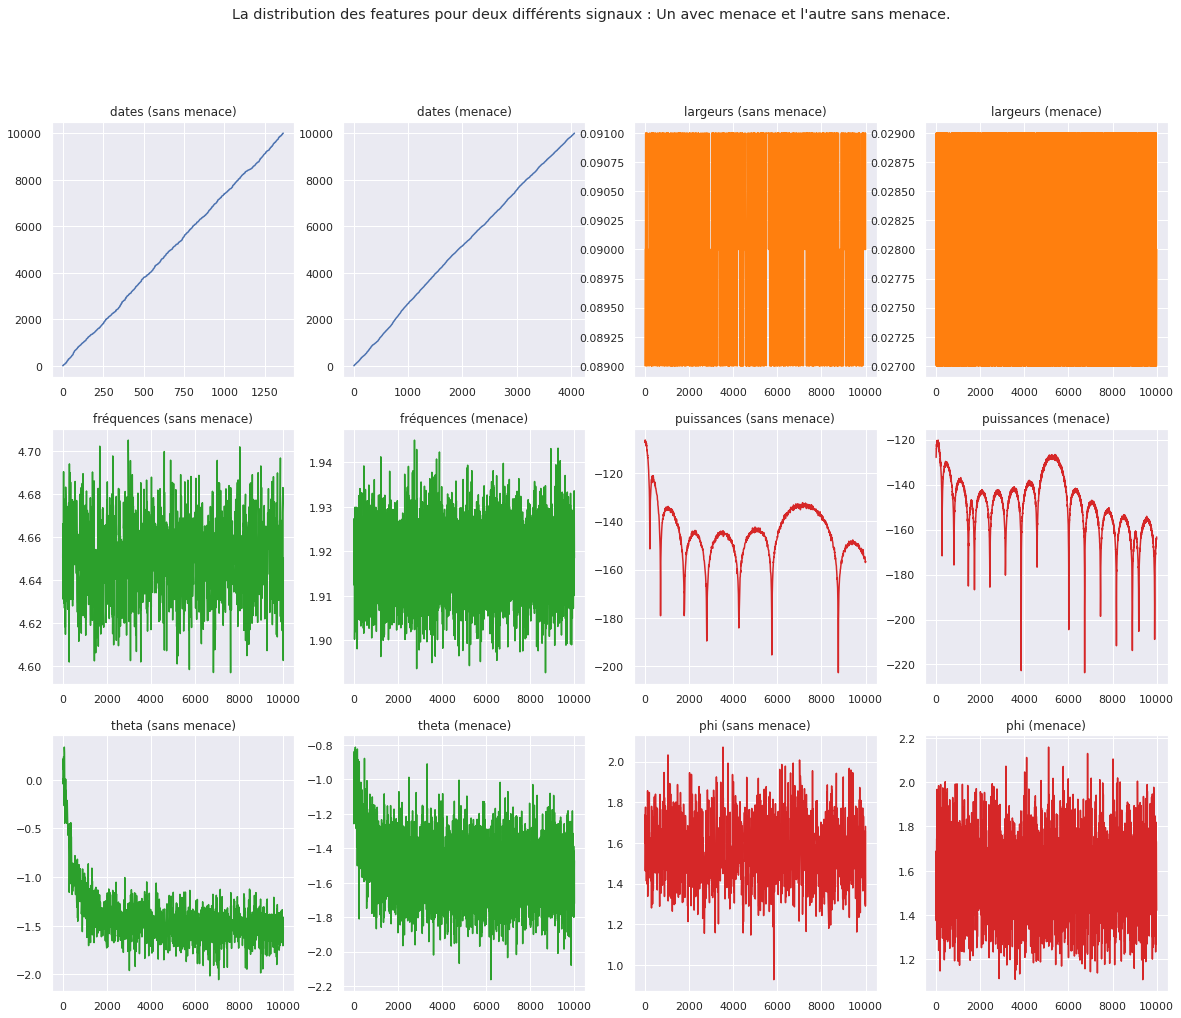

In [ ]:
sns.set_theme()
fig, axs = plt.subplots(3, 4, figsize=(20, 16))
plt.suptitle("La distribution des features pour deux différents signaux : Un avec menace et l'autre sans menace.")
axs[0, 0].plot(dates)
axs[0, 0].set_title('dates (sans menace)')
axs[0, 1].plot(dates_men)
axs[0, 1].set_title('dates (menace)')
axs[0, 2].plot(dates, largeurs, 'tab:orange')
axs[0, 2].set_title('largeurs (sans menace)')
axs[0, 3].plot(dates_men, largeurs_men, 'tab:orange')
axs[0, 3].set_title('largeurs (menace)')
axs[1, 0].plot(dates, frequences, 'tab:green')
axs[1, 0].set_title('fréquences (sans menace)')
axs[1, 1].plot(dates_men, frequences_men, 'tab:green')
axs[1, 1].set_title('fréquences (menace)')
axs[1, 2].plot(dates, puissances, 'tab:red')
axs[1, 2].set_title('puissances (sans menace)')
axs[1, 3].plot(dates_men, puissances_men, 'tab:red')
axs[1, 3].set_title('puissances (menace)')
axs[2, 0].plot(dates, theta, 'tab:green')
axs[2, 0].set_title('theta (sans menace)')
axs[2, 1].plot(dates_men, theta_men, 'tab:green')
axs[2, 1].set_title('theta (menace)')
axs[2, 2].plot(dates, phi, 'tab:red')
axs[2, 2].set_title('phi (sans menace)')
axs[2, 3].plot(dates_men, phi_men, 'tab:red')
axs[2, 3].set_title('phi (menace)')

#### Commentaire :

D'après les figures ci-dessus, on peut remarquer qu'il y a beaucoup de différences entre les deux signaux. 

- D'abord, on peut voir que les valeurs prises par la largeurs ne sont pas les mêmes, ainsi la moyenne de la largeur de chaque signal (menace vs non menace) est différente. Pour le signal sans menace, on constate que la largeur tourne autour de 0.09 et celle du signal avec menace se situe vers 0.028. 

- Pour les fréquences, on peut constater la même chose entre les deux signaux. Celui avec menace a une moyenne autour de 4.65 alors que celui sans menace a une moyenne de 1.92.

- Pour les puissances, on a une toute petite différence dans la moyenne et la variance des deux signaux mais on constate également que la puissance a tendance d'être presque periodique avec la periode du signal avec menace et petite que celle du signal sans menace. 

- Pour les angles $\theta$ et $\phi$, on constate presque la même chose, une variance grande pour le signal avec menace par rapport à l'autre signal. La différence de moyenne n'est pas très significative entre les deux signaux.

- En plus, on regarde que la courbe de la date n'est pas très significatif, ainsi pour utiliser ce paramètre on va extraire les durées entre chaque deux impulsions consécutives et on analysera la moyenne et la variance de ce nouveau paramètre qu'on appelera "difference_dates".

Finalement, tant que la différence entre les deux types de signaux ne peut être généralisée à partir de deux examples, alors on va essayer de voir la distribution de la  moyenne et de la variance de chaque paramètre (fréquence, puissance ...)

In [ ]:
def get_mean_diff_date(dates):
  """
  Une fonction qui calcule la moyenne des durées entre chaque deux impulsions
  dates : le paramètre date d'un signal contenant les dates des impulsions
  return : la moyenne des durées entre chaque deux impulsions
  """
  return np.mean([dates[i] - dates[i - 1] for i in range(1, len(dates))])

def get_var_diff_date(dates):
  """
  Une fonction qui calcule la variance des durées entre chaque deux impulsions
  dates : le paramètre date d'un signal contenant les dates des impulsions
  return : la variance des durées entre chaque deux impulsions
  """
  return np.var([dates[i] - dates[i - 1] for i in range(1, len(dates))])

In [ ]:
PARAMETERS = ["date", "frequence", "largeur", "puissance", "theta", "phi"]
def apply_mean(df):
  """
  Cette fonction applique la moyenne sur chaque paramètre de la data frame sauf le label et la date, pour la date 
  on applique la moyenne sur les durées entre chaque deux impulsions
  """
  mean_df = pd.DataFrame()
  for parameter in PARAMETERS:
    if parameter == "date":
      mean_df["mean_dates"] = df[parameter].apply(get_mean_diff_date)
    else:
      mean_df["mean_" + parameter] = df[parameter].apply(np.mean)
  mean_df["label"] = df["label"]
  return mean_df

def apply_var(df):
  """
  Cette fonction applique la variance sur chaque paramètre de la data frame sauf le label et la date, pour la date 
  on applique la variance sur les durées entre chaque deux impulsions
  """
  var_df = pd.DataFrame()
  for parameter in PARAMETERS:
    if parameter == "date":
      var_df["var_dates"] = df[parameter].apply(get_var_diff_date)
    else:
      var_df["var_" + parameter] = df[parameter].apply(np.var)
  var_df["label"] = df["label"]
  return var_df

In [ ]:
# On applique la moyenne et la variance sur nos paramètres
df_mean_train = apply_mean(df_train) #Une dataframe contenant la moyenne de chaque paramètre 
df_var_train = apply_var(df_train) #Une dataframe contenant la variance de chaque paramètre 

In [ ]:
df_mean_train.head()

,mean_dates,mean_frequence,mean_largeur,mean_puissance,mean_theta,mean_phi,label
0,7.328465,4.650120,0.090031,-144.685642,-1.424540,1.569602,0
0,2.459299,1.917764,0.028000,-148.943209,-1.513623,1.572314,1
0,3.421121,2.390319,0.030004,-163.313557,-1.640993,1.571433,0
0,9.663347,2.387325,0.207967,-159.263884,-1.452575,1.564880,1
0,9.955773,1.369294,0.089985,-152.408178,-1.619195,1.570601,0


In [ ]:
df_var_train.head()

,var_dates,var_frequence,var_largeur,var_puissance,var_theta,var_phi,label
0,46.621000,0.000343,6.759763e-07,122.308219,0.086934,0.024803,0
0,5.445278,0.000058,6.676504e-07,173.909123,0.030736,0.024551,1
0,10.864996,0.000094,6.715505e-07,104.997534,0.031921,0.025269,0
0,86.637250,0.000101,6.571935e-07,163.505375,0.142083,0.024231,1
0,82.707760,0.000027,6.747514e-07,123.664587,0.030134,0.023992,0


In [ ]:
def get_parameter_label(df, parameter):
  """
  Une fonctionne retourne deux listes contenant les valeurs d'un paramètres selon le label
  df : la dataframe dont on va extraire les données
  parameter : le paramètre dont on cherche les valeurs selon le label (fréquence, puissance ...)
  return : deux listes (param_menace : contenant les valeurs selon le label 1 - param_non_menace : contenant les valeurs selon le label 0)
  """
  param_menace = []
  param_non_menace = []
  for i in range(df.shape[0]):
    if df['label'].iloc[[i]][0] == 1:
      param_menace.append(df[parameter].iloc[[i]][0])
    else:
      param_non_menace.append(df[parameter].iloc[[i]][0])
  return param_menace, param_non_menace

In [ ]:
mean_frequence_menace, mean_frequence_non_menace = get_parameter_label(df_mean_train, "mean_frequence")
var_frequence_menace, var_frequence_non_menace = get_parameter_label(df_var_train, "var_frequence")
mean_puissance_menace, mean_puissance_non_menace = get_parameter_label(df_mean_train, "mean_puissance")
var_puissance_menace, var_puissance_non_menace = get_parameter_label(df_var_train, "var_puissance")
mean_largeur_menace, mean_largeur_non_menace = get_parameter_label(df_mean_train, "mean_largeur")
var_largeur_menace, var_largeur_non_menace = get_parameter_label(df_var_train, "var_largeur")
mean_theta_menace, mean_theta_non_menace = get_parameter_label(df_mean_train, "mean_theta")
var_theta_menace, var_theta_non_menace = get_parameter_label(df_var_train, "var_theta")
mean_phi_menace, mean_phi_non_menace = get_parameter_label(df_mean_train, "mean_phi")
var_phi_menace, var_phi_non_menace = get_parameter_label(df_var_train, "var_phi")
mean_dates_menace, mean_dates_non_menace = get_parameter_label(df_mean_train, "mean_dates")
var_dates_menace, var_dates_non_menace = get_parameter_label(df_var_train, "var_dates")

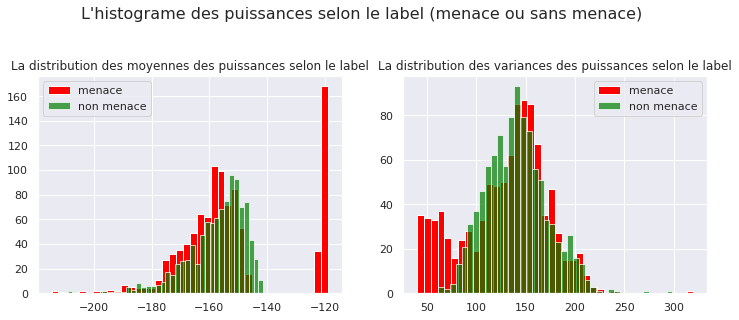

In [ ]:
sns.set_theme()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle("L'histograme des puissances selon le label (menace ou sans menace)", size=16, y=1.12)
axs[0].hist(mean_puissance_menace, color = "red", bins = 40)
axs[0].hist(mean_puissance_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[0].legend(["menace", "non menace"])
axs[0].set_title("La distribution des moyennes des puissances selon le label")
axs[1].hist(var_puissance_menace, color = "red", bins = 40)
axs[1].hist(var_puissance_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[1].legend(["menace", "non menace"])
axs[1].set_title("La distribution des variances des puissances selon le label")
plt.show()

- Pour la moyenne des puissances, on peut constater qu'on a plusieurs signaux sans menace qui sont isolés dans les petites valeurs (autour de moyenne = - 120) alors que les autres signaux ont à peu près la même distribution. 

- de même pour la variance, on a des signaux sans menace qui sont isolés dans les petites valeurs (autous de variance = 50) mais le reste des valeurs suivent à peu près la même distribution que les signaux sans menace.

- Finalement, on remarque que les deux distribution des signaux sans menace suivent à peu près une loi normale de moyenne 150 pour la variance et -150 pour la moyenne la puissance.

Finalement, ces deux valeurs peuvent être informatives pour la prédiction.


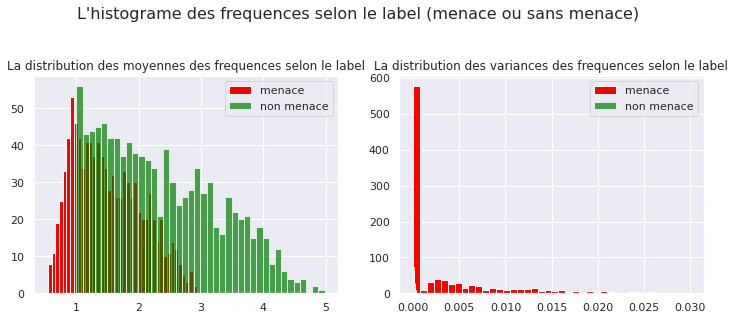

In [ ]:
sns.set_theme()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle("L'histograme des frequences selon le label (menace ou sans menace)", size=16, y=1.12)
axs[0].hist(mean_frequence_menace, color = "red", bins = 40)
axs[0].hist(mean_frequence_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[0].legend(["menace", "non menace"])
axs[0].set_title("La distribution des moyennes des frequences selon le label")
axs[1].hist(var_frequence_menace, color = "red", bins = 40)
axs[1].hist(var_frequence_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[1].legend(["menace", "non menace"])
axs[1].set_title("La distribution des variances des frequences selon le label")
plt.show()

- Pour les fréquences, on peut voir que la moyenne des fréquences des signaux sans menace sont bien étalées entre 1 et 5, par contre celles des signaux menace restent dans les petites valeurs; entre 0.3 et 3.
- Pour les variances, on peut voir que les signaux non menace ont une variance très très petite par rapport à celles des signaux menace.

De même, ces deux valeurs peuvent être informatives pour la prédiction.

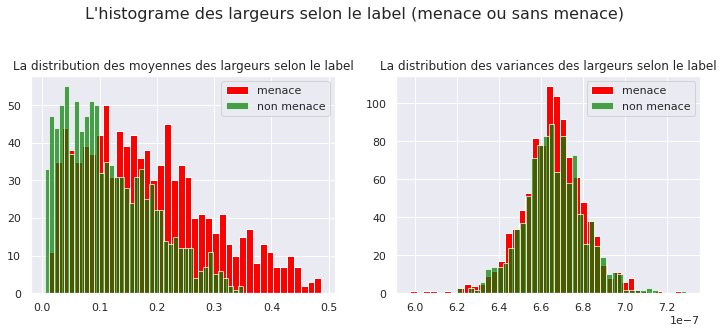

In [ ]:
sns.set_theme()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle("L'histograme des largeurs selon le label (menace ou sans menace)", size=16, y=1.12)
axs[0].hist(mean_largeur_menace, color = "red", bins = 40)
axs[0].hist(mean_largeur_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[0].legend(["menace", "non menace"])
axs[0].set_title("La distribution des moyennes des largeurs selon le label")
axs[1].hist(var_largeur_menace, color = "red", bins = 40)
axs[1].hist(var_largeur_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[1].legend(["menace", "non menace"])
axs[1].set_title("La distribution des variances des largeurs selon le label")
plt.show()

- D'après les figures ci-dessus, on voit que l'histogramme des largeurs de signaux sans menace a une distribution différente de celle avec menace. En effet, on constate que plusieurs signaux menace ont une grande moyenne de largeur. 
- La distribution de variance est presque la même dans les deux genres de signaux. Elle suit une loi normale de moyenne autours de 6.6.

La valeur de la moyenne de largeur sera la plus informative pour prédire.

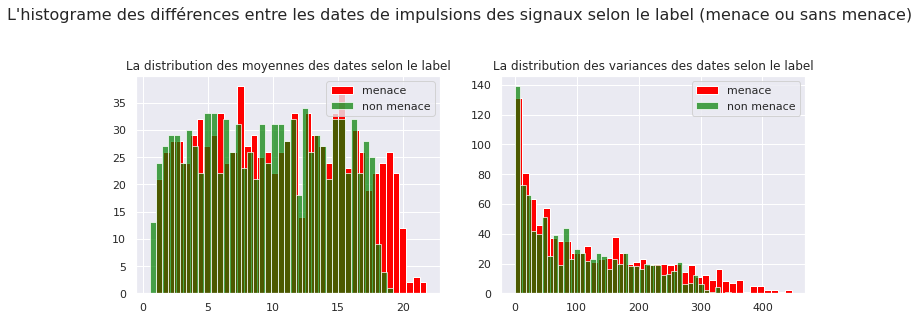

In [ ]:
sns.set_theme()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle("L'histograme des différences entre les dates de impulsions des signaux selon le label (menace ou sans menace)", size=16, y=1.12)
axs[0].hist(mean_dates_menace, color = "red", bins = 40)
axs[0].hist(mean_dates_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[0].legend(["menace", "non menace"])
axs[0].set_title("La distribution des moyennes des dates selon le label")
axs[1].hist(var_dates_menace, color = "red", bins = 40)
axs[1].hist(var_dates_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[1].legend(["menace", "non menace"])
axs[1].set_title("La distribution des variances des dates selon le label")
plt.show()

- On peut voir que la distribution des moyennes est presque la même pour les petites valeurs, mais pour les valeurs aux alentours de 20 sont prises que par les signaux menaces, ainsi on peut tester l'utilisation de ce feature. 
- Pour les variances, on a presque la même distribution. 

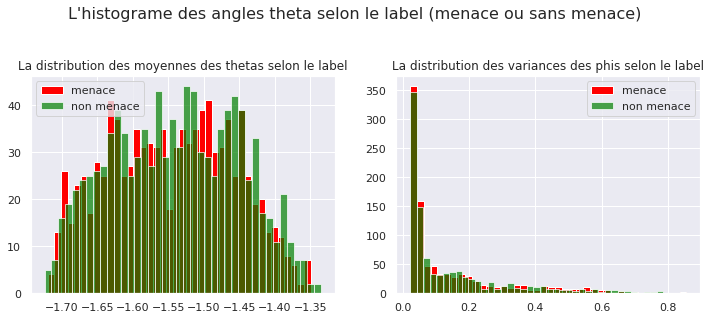

In [ ]:
sns.set_theme()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle("L'histograme des angles theta selon le label (menace ou sans menace)", size=16, y=1.12)
axs[0].hist(mean_theta_menace, color = "red", bins = 40)
axs[0].hist(mean_theta_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[0].legend(["menace", "non menace"])
axs[0].set_title("La distribution des moyennes des thetas selon le label")
axs[1].hist(var_theta_menace, color = "red", bins = 40)
axs[1].hist(var_theta_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[1].legend(["menace", "non menace"])
axs[1].set_title("La distribution des variances des phis selon le label")
plt.show()

- Dans ce cas, on peut voir que les histogrammes de moyennes et de variances des angles theta signaux suivent la même distribution pour les deux genres de signaux. 
Ainsi, on peut conclure que la moyenne et la variance de theta ne portent pas d'informations pour décider si un signal est menace ou non. 

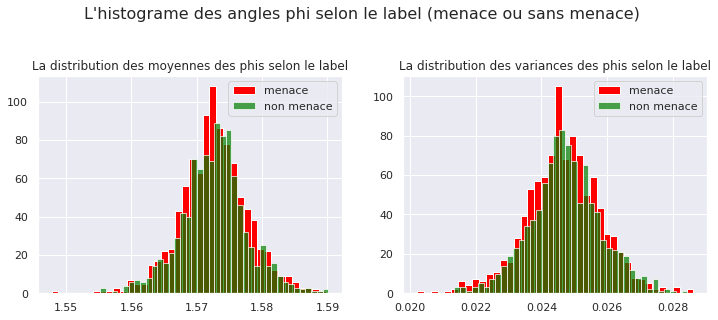

In [ ]:
sns.set_theme()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle("L'histograme des angles phi selon le label (menace ou sans menace)", size=16, y=1.12)
axs[0].hist(mean_phi_menace, color = "red", bins = 40)
axs[0].hist(mean_phi_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[0].legend(["menace", "non menace"])
axs[0].set_title("La distribution des moyennes des phis selon le label")
axs[1].hist(var_phi_menace, color = "red", bins = 40)
axs[1].hist(var_phi_non_menace, color = "green", bins = 40, alpha = 0.7)
axs[1].legend(["menace", "non menace"])
axs[1].set_title("La distribution des variances des phis selon le label")
plt.show()

- De même que les angles theta, on peut voir que les histogrammes de moyennes et de variances des angles phi des signaux suivent la même distribution pour les deux genres de signaux. 
Ainsi, on peut conclure que la moyenne et la variance de theta ne portent pas d'informations pour décider si un signal est menace ou non. 

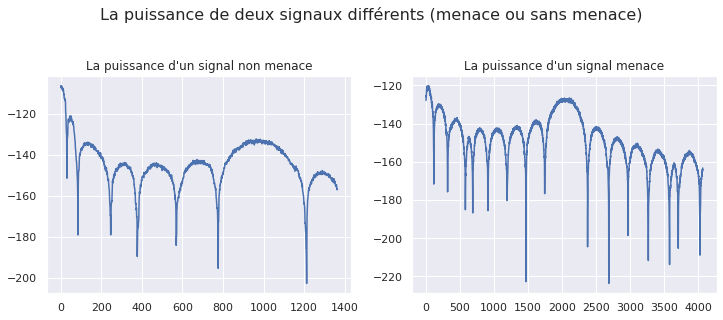

In [ ]:
sns.set_theme()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle("La puissance de deux signaux différents (menace ou sans menace)", size=16, y=1.12)
axs[0].plot(df_train.iat[0, 3])
axs[0].set_title("La puissance d'un signal non menace")
axs[1].plot(df_train.iat[1, 3])
axs[1].set_title("La puissance d'un signal menace")
plt.show()

Dans cette figure, on peut constater la puissance a une courbe presque périodique. On a la puissance d'un signal non menace a moins de périodes que la puissance du signal menace. Ainsi, un des features qu'on peut utiliser est le nombre de maximum de puissances. Pour ce faire, on calculera la dérivée de la puissance et compter le nombre de passage par zero. Ce calcul de dérivée sera suivi par l'élimination de bruit en utilisant les splines d'Hermites.

In [ ]:
from scipy.interpolate import splrep, splev
from scipy.interpolate import UnivariateSpline
puissances_non_menace = df_train.iat[0, 3]
puissances_menace = df_train.iat[1, 3]
derivee_puissance_non_menaces = np.gradient(puissances_non_menace)
derivee_puissance_menaces = np.gradient(puissances_menace)
x1 = np.arange(0, len(derivee_puissance_non_menaces), 1)
x2 = np.arange(0, len(derivee_puissance_menaces), 1)
spl1 = UnivariateSpline(x1, derivee_puissance_non_menaces)
spl2 = UnivariateSpline(x2, derivee_puissance_menaces)

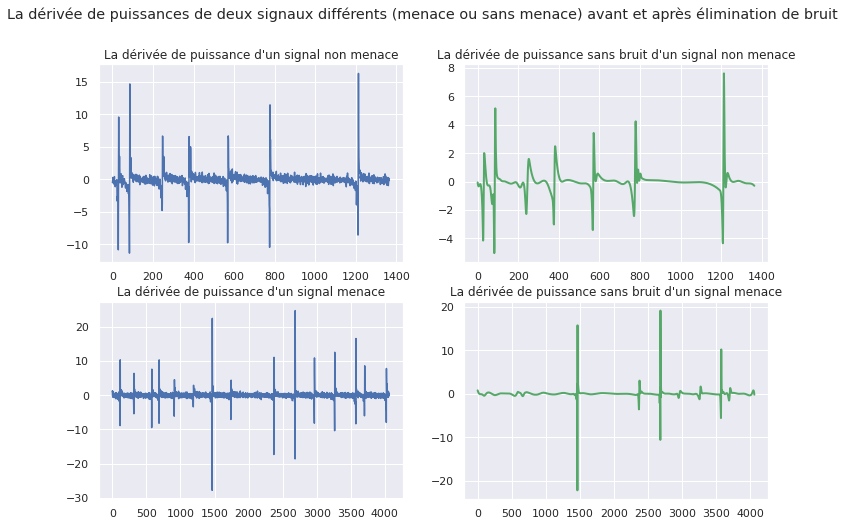

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.suptitle("La dérivée de puissances de deux signaux différents (menace ou sans menace) avant et après élimination de bruit")
axs[0, 0].plot(derivee_puissance_non_menaces)
axs[0, 0].set_title("La dérivée de puissance d'un signal non menace")
axs[0, 1].plot(x1, spl1(x1), 'g', lw=2)
axs[0, 1].set_title("La dérivée de puissance sans bruit d'un signal non menace")
axs[1, 0].plot(derivee_puissance_menaces)
axs[1, 0].set_title("La dérivée de puissance d'un signal menace")
axs[1, 1].plot(x2, spl2(x2), 'g', lw=2)
axs[1, 1].set_title("La dérivée de puissance sans bruit d'un signal menace")

plt.show()

Conclusion :
- Pour la parties de l'entrainement de modèles et à partir de l'analyse faite précédamment, on va essayer trois distributions de features.
- D'abord, on va essayer une approche naive qui se base que sur les moyennes des features.
- Après, on essayera de combiner toutes les moyennes et les variances.
- Finalement, on essayera de se baser sur le précédent analyse et prendre : la moyenne des différences des dates d'impulsion - La moyenne des largeurs - la moyenne et la variation des fréquences - la moyenne et la variation des puissanes ainsi que le nombre de maximum de la puissance des signaux.

### Entrainement de modèles


#### Features - set 1 : Moyennes de tous les paramètres

In [ ]:
def train_models(X, y, X_test, y_test):
  """
  une fonction qui fait un entrainement de différent modèles de classification de sklearn
  """
  names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
  ]

  classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
  ]

  for name, clf in zip(names, classifiers):
        clf.fit(X, y)
        score = clf.score(X_test, y_test)
        print(f"The score of {name} is {score}")

In [ ]:
# On applique la moyenne et la variance sur nos paramètres de la test dataset
df_mean_test = apply_mean(df_test) #Une dataframe contenant la moyenne de chaque paramètre 

In [ ]:
X_train = df_mean_train[df_mean_train.columns.difference(['label'])]
y_train = df_mean_train['label']
X_test = df_mean_test[df_mean_test.columns.difference(['label'])]
y_test = df_mean_test['label']
train_models(X_train, y_train, X_test, y_test)

The score of Nearest Neighbors is 0.67875
The score of Linear SVM is 0.7075
The score of RBF SVM is 0.6975


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


The score of Gaussian Process is 0.78875
The score of Decision Tree is 0.74625
The score of Random Forest is 0.7525
The score of Neural Net is 0.68875
The score of AdaBoost is 0.7925
The score of Naive Bayes is 0.7
The score of QDA is 0.75125


Après avoir appliquer plusieurs modèles sur notre dataset, on trouve que AdaBoost donne la meilleur accuracy : 79.25% . La prochaine étape est de faire un grid search sur quelques paramètres du modèle afin de booster le score.

#### Grid search sur learning rate :

In [ ]:
lrs = np.arange(0.0001, 1.5, 0.01)
accuracy_values_Ada = []
for lr in tqdm(lrs):
    ADC = AdaBoostClassifier(learning_rate = lr).fit(X_train, y_train)
    score = ADC.score(X_test, y_test)
    accuracy_values_Ada.append(score)

100%|██████████| 150/150 [00:36<00:00,  4.16it/s]


Text(0.5, 1.0, "Le changement ed l'accuracy selon le learning rate.")

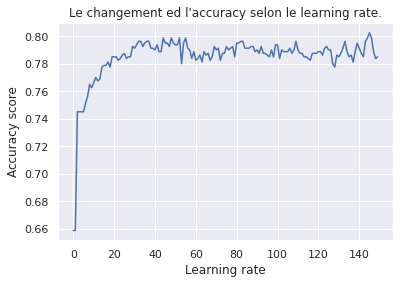

In [ ]:
plt.plot(accuracy_values_Ada)
plt.xlabel("Learning rate")
plt.ylabel("Accuracy score")
plt.title("Le changement ed l'accuracy selon le learning rate.")

In [ ]:
print(f"Le meilleur learning rate de AdaBoost est : {lrs[np.argmax(accuracy_values_Ada)]} avec une accuracy de : {max(accuracy_values_Ada)}" ) 

Le meilleur learning rate de AdaBoost est : 1.4501 avec une accuracy de : 0.8025


#### Grid search sur Adaboost's n_estimators :

In [ ]:
n_estimators = np.arange(1, 200, 1)
accuracy_values_Ada = []
for n in tqdm(n_estimators):
    ADC = AdaBoostClassifier(learning_rate = 1.4501, n_estimators = n).fit(X_train, y_train)
    score = ADC.score(X_test, y_test)
    accuracy_values_Ada.append(score)

100%|██████████| 199/199 [01:26<00:00,  2.30it/s]


Text(0.5, 1.0, "Le changement de l'accuracy selon n_estimators.")

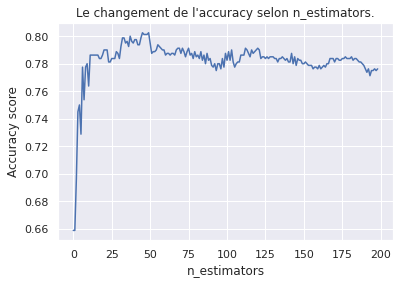

In [ ]:
plt.plot(accuracy_values_Ada)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy score")
plt.title("Le changement de l'accuracy selon n_estimators.")

In [ ]:
print(f"Le meilleur n_estimators de AdaBoost est {n_estimators[np.argmax(accuracy_values_Ada)]} avec une accuracy de : {max(accuracy_values_Ada)}" ) 

Le meilleur n_estimators de AdaBoost est 46 avec une accuracy de : 0.8025


On constate que le paramètre de n_estimators n'a pas trop affecté le score de notre modèle.

#### Confusion matrix

In [ ]:
!pip install pretty_confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

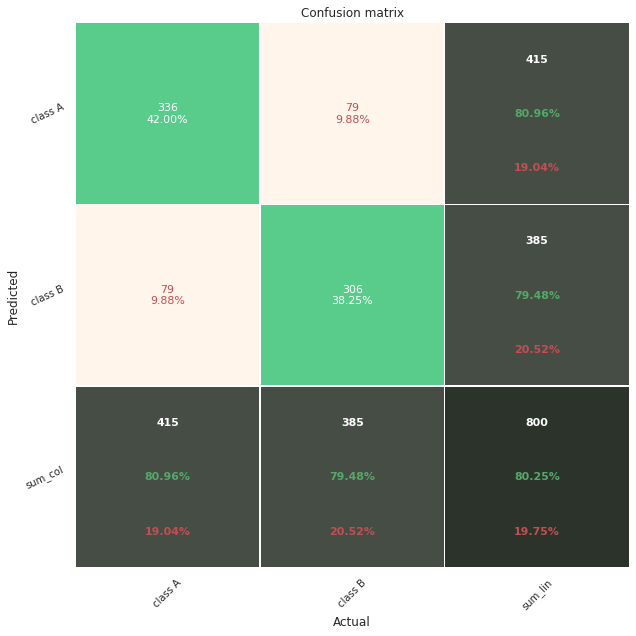

In [ ]:
from sklearn.metrics import confusion_matrix
from pretty_confusion_matrix import pp_matrix_from_data
y_pred = AdaBoostClassifier(learning_rate = 1.4501, n_estimators = 46).fit(X_train, y_train).predict(X_test)
pp_matrix_from_data(y_test, y_pred)

Dans pour ce premier ensemble de features, on a 79 mal classés éléments pour chaque label. Par contre, on a 336 bien classé éléments de la **classe A** (qui correspond aux signaux sans menace) et 306 dans la **classe B** (qui correspond aux signaux menace).

### Features - set 2 : La moyenne et La variance de tous les paramètres

In [ ]:
#Une data frame qui combine les deux ddescripteurs statistiques de chaque colonne
df_stats = pd.concat([df_mean_train, df_var_train], axis=1)

In [ ]:
#Extraire les données et le label
X_stats, Y_stats = df_stats[df_stats.columns.difference(['label'])], df_stats['label']
#La label est dupliqué donc on supprime une colonne
Y_stats = df_train['label']

In [ ]:
#Dans cette partie, on essayera de faire la même chose pour les données de test
df_mean_test = apply_mean(df_test)
df_var_test = apply_var(df_test)
df_stats_test = pd.concat([df_mean_test, df_var_test], axis=1)
X_stats_test, Y_stats_test = df_stats_test[df_stats_test.columns.difference(['label'])], df_stats_test['label']
#Le label est dupliqué donc on supprime une colonne
Y_stats_test = df_test['label']

In [ ]:
#On entraine nos modèles sur ce nouveau ensemble de features
train_models(X_stats, Y_stats, X_stats_test, Y_stats_test)

The score of Nearest Neighbors is 0.59625
The score of Linear SVM is 0.70625
The score of RBF SVM is 0.52125


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


The score of Gaussian Process is 0.7775
The score of Decision Tree is 0.82875
The score of Random Forest is 0.8175
The score of Neural Net is 0.6825
The score of AdaBoost is 0.84
The score of Naive Bayes is 0.74
The score of QDA is 0.79875


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


D'après ces résultats, AdaBoost est l'algorithm qui donne encore une fois les meilleurs résultats. On essayera comme précédemment de faire un grid search sur les paramètres.

#### Grid search sur AdaBoost's learning rate :

In [ ]:
lrs = np.arange(0.0001, 1.5, 0.01)
accuracy_values_Ada = []
for lr in tqdm(lrs):
    ADC = AdaBoostClassifier(learning_rate = lr).fit(X_stats, Y_stats)
    score = ADC.score(X_stats_test, Y_stats_test)
    accuracy_values_Ada.append(score)

100%|██████████| 150/150 [00:46<00:00,  3.25it/s]


Text(0.5, 1.0, "Le changement de l'accuracy selon le learning rate.")

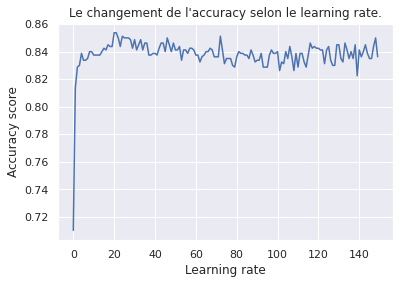

In [ ]:
plt.plot(accuracy_values_Ada)
plt.xlabel("Learning rate")
plt.ylabel("Accuracy score")
plt.title("Le changement de l'accuracy selon le learning rate.")

In [ ]:
print(f"Le meilleur learning rate de AdaBoost est : {lrs[np.argmax(accuracy_values_Ada)]} avec une accuracy de : {max(accuracy_values_Ada)}" ) 

Le meilleur learning rate de AdaBoost est : 0.2001 avec une accuracy de : 0.85375


#### Grid search sur AdaBoost's n_estimators :

In [ ]:
n_estimators = np.arange(1, 200, 1)
accuracy_values_Ada = []
for n in tqdm(n_estimators):
    ADC = AdaBoostClassifier(learning_rate = 1.41, n_estimators = n).fit(X_stats, Y_stats)
    score = ADC.score(X_stats_test, Y_stats_test)
    accuracy_values_Ada.append(score)

100%|██████████| 199/199 [02:09<00:00,  1.54it/s]


Text(0.5, 1.0, "Le changement de l'accuracy selon le n_estimators.")

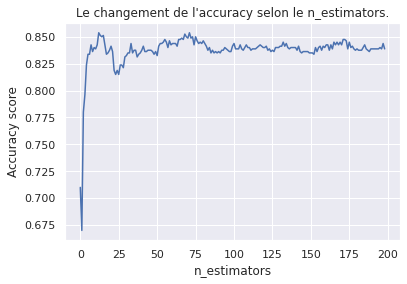

In [ ]:
plt.plot(accuracy_values_Ada)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy score")
plt.title("Le changement de l'accuracy selon le n_estimators.")

In [ ]:
print(f"Le meilleur n_estimators de AdaBoost est {n_estimators[np.argmax(accuracy_values_Ada)]} avec une accuracy de : {max(accuracy_values_Ada)}" ) 

Le meilleur n_estimators de AdaBoost est 13 avec une accuracy de : 0.85375


/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

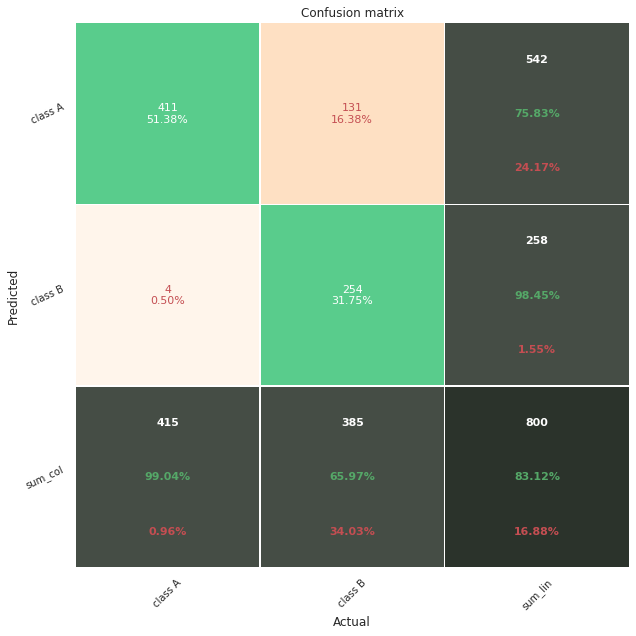

In [ ]:
from sklearn.metrics import confusion_matrix
from pretty_confusion_matrix import pp_matrix_from_data
y_pred = AdaBoostClassifier(learning_rate = 0.2001, n_estimators = 13).fit(X_stats, Y_stats).predict(X_stats_test)
pp_matrix_from_data(Y_stats_test, y_pred)

Dans ce deuxième ensemble de features, on a 131 signaux menace qui sont classés comme sans menace et 4 signaux sans menace classée comme menace.

Dans ce deuxième ensemble de features, on a score plus élevé que le premier. En effet, les moyennes des paramètres ne capturent pas toutes les informations nécessaires. Ainsi, avec l'ajout des variances on a beaucoup plus d'informations qui fait que l'algorithme soit un peu plus précis par rapport à l'utilisation du premier ensemble de features. Dans la prochaine partie, on va essayer d'utiliser le troisième ensemble de features qui est plutôt basé sur l'analyse faite dans la première partie. Pour rappeler, le troisième ensemble contient :  
- la moyenne des différences des dates d'impulsion 
- La moyenne des largeurs 
- la moyenne et la variation des fréquences 
- la moyenne et la variation des puissances et le nombre de maximum de la puissance des signaux.

Avant d'éxecuter notre modèle sur cet ensemble, on va d'abord voir sur quoi AdaBoost s'est appuyé pour avoir le score précédent. Pour ce faire, on va faire appel à "features_importance" de notre modèle.

Text(0, 0.5, "Pourcentage de l'imporatnce des features")

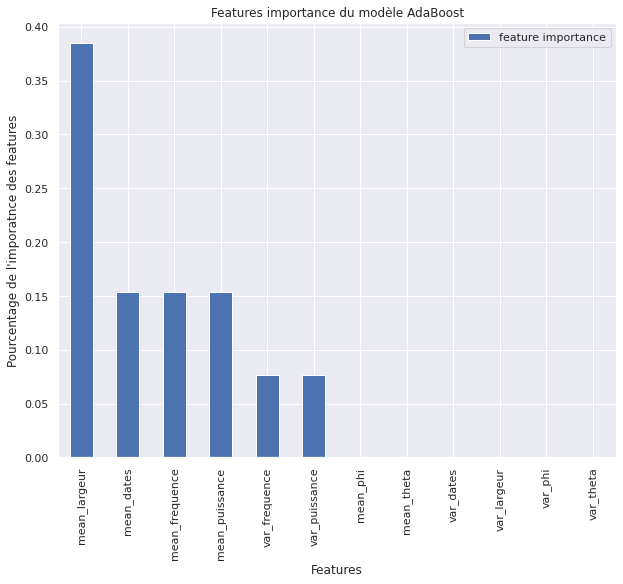

In [ ]:
ADC = AdaBoostClassifier(learning_rate = 1.41, n_estimators = 13).fit(X_stats, Y_stats)
df_feature_importance = pd.DataFrame(ADC.feature_importances_, index=list(X_stats.columns), columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance.plot(kind='bar', figsize = (10, 8))
plt.title("Features importance du modèle AdaBoost")
plt.xlabel("Features")
plt.ylabel("Pourcentage de l'imporatnce des features")

D'après cette figure, on peut voir que les paramètres qui sont prises en compte, sont éxactement ceux qui appartiennent à l'ensemble 3 des paramètres qu'on a détecter de l'analyse faite dans la pemière partie (sauf le nombre de de maximaux de puissances). En plus, on remarque que l'algorithme s'appuie sur la moyenne de la largeur avec un pourcentage de 38%. Ce qui est plutôt cohérent avec la distribution des moyennes des largeurs qui est différente entre les deux genres de signaux. 

### Features - set 3:

In [ ]:
X_stats.drop(["mean_phi", "mean_theta", "var_dates", "var_largeur", "var_phi", "var_theta"], axis = 1, inplace = True)
X_stats_test.drop(["mean_phi", "mean_theta", "var_dates", "var_largeur", "var_phi", "var_theta"], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
def zero_crossing_puissances(puissances):
  """
  Cette fonction rends le nombre de passage par zero de la dérivée de puissance
  puissances : les puissances des impulsions d'un signal.
  return : le nombre de passage par zero de la dérivée de puissance
  """
  derivee_puissance = np.gradient(puissances)
  x = np.arange(0, len(derivee_puissance), 1)
  spl = UnivariateSpline(x, derivee_puissance)
  return ((spl(x)[:-1] * spl(x)[1:]) < 0).sum()

In [ ]:
X_stats["max_puissances"] = df_train["puissance"].apply(zero_crossing_puissances)
X_stats_test["max_puissances"] = df_test["puissance"].apply(zero_crossing_puissances)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_models(X_stats, Y_stats, X_stats_test, Y_stats_test)

The score of Nearest Neighbors is 0.71375
The score of Linear SVM is 0.77625
The score of RBF SVM is 0.565


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


The score of Gaussian Process is 0.51875
The score of Decision Tree is 0.8675
The score of Random Forest is 0.88625
The score of Neural Net is 0.77875
The score of AdaBoost is 0.88875
The score of Naive Bayes is 0.835
The score of QDA is 0.81875


D'après ces valeurs, AdaBoost est encore l'algorithme avec les meilleurs résultats, et on fera de même manière le grid search sur les paramètres.

#### Grid Search sur le learning rate :

In [ ]:
lrs = np.arange(0.0001, 1.5, 0.01)
accuracy_values_Ada = []
for lr in tqdm(lrs):
    ADC = AdaBoostClassifier(learning_rate = lr).fit(X_stats, Y_stats)
    score = ADC.score(X_stats_test, Y_stats_test)
    accuracy_values_Ada.append(score)

100%|██████████| 150/150 [00:34<00:00,  4.38it/s]


Text(0.5, 1.0, "Le changement de l'accuracy selon le learning rate.")

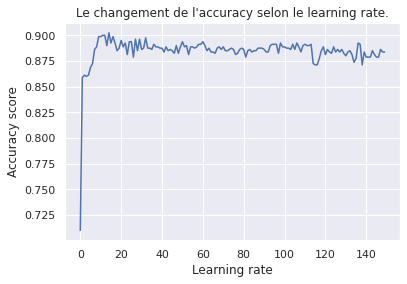

In [ ]:
plt.plot(accuracy_values_Ada)
plt.xlabel("Learning rate")
plt.ylabel("Accuracy score")
plt.title("Le changement de l'accuracy selon le learning rate.")

In [ ]:
print(f"Le meilleur learning rate de AdaBoost est : {lrs[np.argmax(accuracy_values_Ada)]} avec une accuracy de : {max(accuracy_values_Ada)}" ) 

Le meilleur learning rate de AdaBoost est : 0.1401 avec une accuracy de : 0.9025


Ainsi, dans ce cas on voit bien l'importance de nouveau feature qui s'appuie sur le nombre de maximum de puissances.
- Optuna est un frameworke qui est très utilisé pour trouver les meillers hyperparameters. Pour ce faire, tu précise les algorithmes à essayer, l'intervalle des hyper-paramètres à essayer pour chaque modèles. Vas-y, on essaye si on peut trouver mieux que le dernier résultat.

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna
def objective(trial):

    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest", "AdaBoost", "MLP"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto")
    
    elif classifier_name == "AdaBoost":
        rf_max_lr1 = trial.suggest_float("rf_max_lr1", 1e-5, 1e10, log=True)
        rf_max_estim = trial.suggest_int("rf_max_estim", 2, 100, log=True)
        classifier_obj = AdaBoostClassifier(n_estimators = rf_max_estim, learning_rate = rf_max_lr1)
    
    elif classifier_name == "MLP":
        rf_max_alpha = trial.suggest_float("rf_max_alpha", 1e-10, 1e10, log=True)
        rf_max_lr = trial.suggest_categorical("rf_max_lr", ["constant", "invscaling", "adaptive"])
        layers = trial.suggest_categorical("layers", [(5, 5), (10, 10), (5, 5, 5), (10, 10, 10)])
        classifier_obj = MLPClassifier(hidden_layer_sizes = layers, alpha = rf_max_alpha, max_iter=1000, learning_rate = rf_max_lr)

    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        rf_max_estim = trial.suggest_int("rf_max_estim", 2, 100, log=True)
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_max_estim
        )

    classifier_obj.fit(X_stats, Y_stats)
    score = classifier_obj.score(X_stats_test, Y_stats_test)
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
print(study.best_trial)

[I 2022-11-08 22:59:46,026] A new study created in memory with name: no-name-478c1305-29a5-4517-9003-ae646308b2dd
[I 2022-11-08 22:59:46,390] Trial 0 finished with value: 0.51875 and parameters: {'classifier': 'SVC', 'svc_c': 0.000584858897320468}. Best is trial 0 with value: 0.51875.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (5, 5) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persiste

FrozenTrial(number=164, values=[0.90125], datetime_start=datetime.datetime(2022, 11, 8, 23, 1, 18, 640823), datetime_complete=datetime.datetime(2022, 11, 8, 23, 1, 18, 818067), params={'classifier': 'AdaBoost', 'rf_max_lr1': 0.14719815773730902, 'rf_max_estim': 37}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest', 'AdaBoost', 'MLP')), 'rf_max_lr1': FloatDistribution(high=10000000000.0, log=True, low=1e-05, step=None), 'rf_max_estim': IntDistribution(high=100, log=True, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=164, state=TrialState.COMPLETE, value=None)


Génial ! On a la même accuracy qu'on a trouvé avec l'utilisation de Grid Search sur AdaBoost avec un score de 90%

Text(0, 0.5, "Pourcentage de l'imporatnce des features")

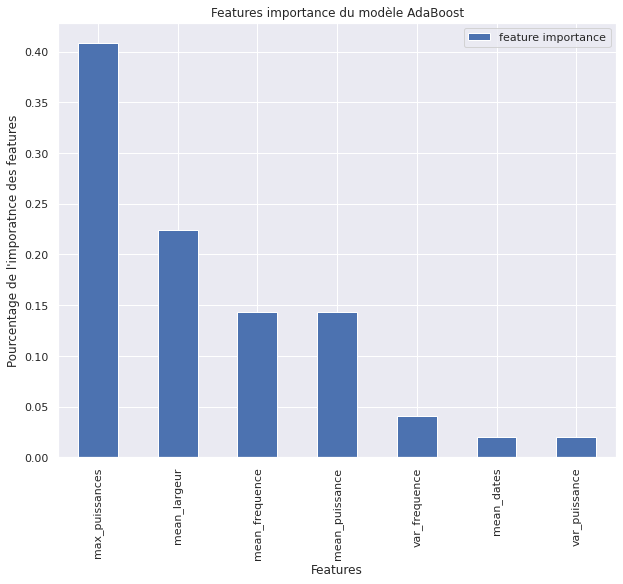

In [ ]:
ADC = AdaBoostClassifier(learning_rate = 0.1401, n_estimators = 49).fit(X_stats, Y_stats)
df_feature_importance = pd.DataFrame(ADC.feature_importances_, index=list(X_stats.columns), columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance.plot(kind='bar', figsize = (10, 8))
plt.title("Features importance du modèle AdaBoost")
plt.xlabel("Features")
plt.ylabel("Pourcentage de l'imporatnce des features")

Génial ! D'après ces résultats, on peut la grande importance du nouveau paramètre qui est plutôt la base sur laquelle il s'appuie pour prédire. AdaBoost s'appuie sur le feature max_puissance (Le nombre de maximum de puissances d'un signal) avec un pourcentage 41% .

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

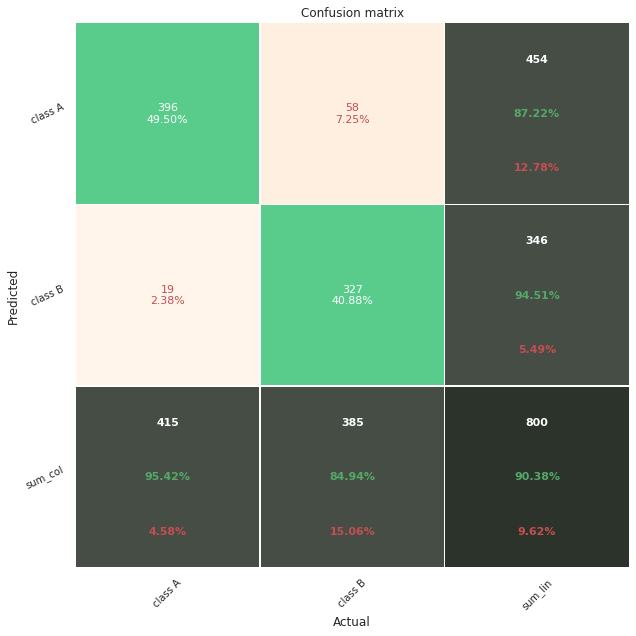

In [ ]:
y_pred = AdaBoostClassifier(learning_rate = 0.1401, n_estimators = 49).fit(X_stats, Y_stats).predict(X_stats_test)
pp_matrix_from_data(Y_stats_test, y_pred)

### Conclusion :

| Features | Accuracy |
| :- | -: |
| Set 1 : Moyennes sur les features | 80 % |
| Set 2 : Moyennes et Variances sur les features | 85 % |
| Set 3 : la moyenne des différences des dates d'impulsion et les largeurs - la moyenne et la variance des fréquences et puissances - le nombre de maximum de la puissances d'un signal. | 90 % |

Pour conclure, On a eu un très bon score à la fin après beaucoup d'essaies et d'analyse sur les features. En effet, On voit que la partie d'analyse, l'étude des features est primordiale dans chaque projet de Machine Learning. Dans ce TP, on a bien vu l'importance de cette étude et comment ça a augmenté le score de l'accuracy de 80% à 90%, ce qui est une une différence assez intéressante. En plus, il y a pas mal d'idées qu'on peut encore faire si on a eu le temps, à savoir:

- Calculer les moments d'ordres 2, 3, 4 .. par exemple si ça peut extraire beaucoup plus d'informations sur nos données.

- On peut aussi, laisser notre signal comme il est et appuyer un modèle basé sur les réseaux de neurones, par exemple un LSTM qui peut capturer la relation entre nos impulsions dans chaque signal. Pour ce faire, on aura besoin d'avoir une longueur fixe pour chaque signal. Ainsi, on peut par exemple en prenant le signal ayant le nombre minimal d'impulsions et prendre le même nombre pour les autres signaux ...

- Peut être qu'un CNN sera une idée intéressante, si par exemple on prend un signal comme une image ayant 6 lignes qui corresponds au features et les colonnes sont les valeurs de chacun. Ainsi, peut être qu'on doit faire juste un Conv1D sur chaque ligne ...

Finalement, un TP très intéressant dont on a pris beaucoup de choses en Features Engineering, l'entrainement de modèles sur Sklearn ainsi que le choix des hyper-paramètres.